# Векторные репрезентации слов и документов
# Часть 5. Нейросетевые модели
# Doc2Vec (Paragraph Vector)

Метод Doc2Vec представляет собой два алгоритма: *distributed memory* (DM, распределенная память) и *distributed bag of words* (DBOW, распределенный мешок слов). DM прогнозирует слово по известным предшествующим словам и вектору абзаца. Несмотря на то, что контекст перемещается по тексту, вектор абзаца не перемещается (отсюда название «распределенная память») и позволяет учесть порядок слов. DBOW прогнозирует случайные группы слов в абзаце только на основании вектора абзаца.  

**Полученные в результате обучения векторы можно подавать на вход классификатора.**

Задействование всех доступных виртуальных ядер [ссылка](https://software.intel.com/en-us/forums/intel-math-kernel-library/topic/294954)

In [3]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import sys
import multiprocessing
from pprint import pprint

# For building models
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# For data manipulating
import random
import pickle
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.decomposition import TruncatedSVD
pd.options.display.max_colwidth = 100

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

%matplotlib inline

Сериализация объектов

In [6]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Загрузка данных
Загружать документы из корпуса будем "лениво".

Обучать модели будем на корпусе размера ~165K статей.
#### Доступ к корпусу можно получить по [ссылке]()

In [7]:
path_data = '~/'
file = path_data + 'corpora_lem.csv'

arxiv_id = pd.read_csv(path_data + 'corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


"Ленивая" загрузка корпуса. Преобразование корпуса к формату, которого требует алгоритм.

In [8]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

class TaggedCorpora:
    def __init__(self, file, n, collocation=False, reduce=1):
        self.file = file
        self.n = n
        self.collocation = collocation
        self.reduce = reduce
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0]
            condition = len(content.split()) < 15000 and i%self.reduce == 0
            if condition:
                if not self.collocation:
                    doc = content.split()
                else:
                    doc = self.collocation[content.split()]
                yield TaggedDocument([token for token in doc if token[0] in alphabet], [row['arxiv_id'].values[0]])

In [9]:
documents = TaggedCorpora(file, n_corpora)

Сканирование словаря

In [6]:
pre = Doc2Vec(min_count=0)
pre.scan_vocab(documents)

In [7]:
pre.scale_vocab(min_count=40, dry_run=True)

{'downsample_total': 303161086,
 'downsample_unique': 40,
 'drop_unique': 435961,
 'memory': {'doctag_lookup': 32615000,
  'doctag_syn0': 65230000,
  'syn0': 21625600,
  'syn1neg': 21625600,
  'total': 168128200,
  'vocab': 27032000},
 'retain_total': 426108818}

### Distributed Memory
[Описание]
![Caption for the picture.](https://4.downloader.disk.yandex.ru/preview/17011cea332572ca5b0b8cb68b081294fbc5c698431cf046a80bcf96b21db8d5/inf/rzF8iT0JFcnHEBA6RCuVoP4siXnpaeYNTiiji29lH5X4IpD0pj_JGKJtVyeaBlD8H0GX1zsAnqGZA3lI9iRy-A%3D%3D?uid=431087183&filename=2.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=1249x532)

Параметры

In [9]:
min_count = 20
size = 200
negative = 5
window = 10
epochs = 10
sample = 1e-5
cores = multiprocessing.cpu_count()

Обучение модели

In [10]:
%%time

# building model
#
model_dm = Doc2Vec(min_count=min_count, dm=1, size=size, window=window, negative=negative, 
                   iter=epochs, workers=cores, sample=sample)

print("Build vocabulary...")
model_dm.build_vocab(documents)

print("Start training...")
model_dm.train(documents, total_examples=model_dm.corpus_count)

Build vocabulary...
Start training...
CPU times: user 4h 54min 36s, sys: 2min 41s, total: 4h 57min 18s
Wall time: 1h 55min 7s


In [24]:
print("Размер словаря: %d" % len(model_dm.wv.vocab))

Размер словаря: 79966


In [98]:
# Saving
#
# path_to_model = '/home/kulesh271828/arxiv/models/doc2vec/'
# model_name = 'dm_200.model'
# model_dm.save(path_to_model + model_name)

In [11]:
# Loading

path_to_model = '/home/kulesh271828/arxiv/models/doc2vec/'
model_name = 'dm_200.model'
model_dm = Doc2Vec.load(path_to_model + model_name)

**Наиболее похожие документы**

In [6]:
corpus_info = pd.read_csv(path_data + 'unique_queries.csv', encoding='cp1252', \
                          usecols=['id', 'title', 'primary_category'], index_col='id')

In [7]:
def most_similar_doc(model, arxiv_id, n=20):
    sim_pairs = model.docvecs.most_similar(positive=[arxiv_id], topn=n)
    sim_df = pd.DataFrame([(_id, corpus_info.loc[_id]['title'], sim) for _id, sim in sim_pairs], \
                         columns=['id','title','similarity'])
    print(corpus_info.loc[arxiv_id]['title'])
    return sim_df

Выведим список статей, которые наиболее "похожи" на статью *Quoc Le and Tomas Mikolov. [Distributed Representations of Sentences and Documents](http://www-cs-faculty.stanford.edu/~quocle/paragraph_vector.pdf)*, в которой описан подход doc2vec.

In [15]:
most_similar_doc(model_dm, '1405.4053v2', n=10)

Distributed Representations of Sentences and Documents


,id,title,similarity
0,1301.3781v3,Efficient Estimation of Word Representations in Vector Space,0.664477
1,1410.3916v11,Memory Networks,0.606655
2,1402.1973v2,Dictionary learning for fast classification based on soft-thresholding,0.601639
3,1412.5335v7,Ensemble of Generative and Discriminative Techniques for Sentiment\r\r\n Analysis of Movie Reviews,0.601210
4,1510.03753v2,Improved Deep Learning Baselines for Ubuntu Corpus Dialogs,0.592403
5,1503.00185v5,When Are Tree Structures Necessary for Deep Learning of Representations?,0.585342
6,1312.3005v3,One Billion Word Benchmark for Measuring Progress in Statistical\r\r\n Language Modeling,0.578944
7,1411.4555v2,Show and Tell: A Neural Image Caption Generator,0.575507
8,1410.1090v1,Explain Images with Multimodal Recurrent Neural Networks,0.575300
9,1403.6652v2,DeepWalk: Online Learning of Social Representations,0.575151


Отметим, что наиболее близкой к данной работе является статья *"Efficient Estimation of Word Representations in Vector Space"*, где описан метод представления слов в виде "сжатого" вектора word2vec, на основании которого разработан doc2vec. Однако, многие документы имеет лишь общую тематическую схожесть с исходным.

### Distributed bag of words
[Описание]
![Caption for the picture.](https://2.downloader.disk.yandex.ru/preview/5a43d23d9d26663c54ee05fa49e6e5c01928c45eaf6124dd2738b11e9d95fac5/inf/rzF8iT0JFcnHEBA6RCuVoLn4ZJK4wH-B7peYLzBES57vLaghbUdolnmt2W1_T3AkQ_2ijcoQxeVh46N4m_yGaw%3D%3D?uid=431087183&filename=3.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=1249x532)

In [94]:
%%time

# building model
#
model_dbow = Doc2Vec(min_count=min_count, dm=0, size=size, window=window, negative=negative, 
                   iter=epochs, workers=cores, sample=sample)

print("Build vocabulary...")
model_dbow.build_vocab(documents)

print("Start training...")
model_dbow.train(documents, total_examples=model_dm.corpus_count)

Build vocabulary...
Start training...
CPU times: user 3h 15min 46s, sys: 2min 12s, total: 3h 17min 59s
Wall time: 1h 52min 58s


In [99]:
# Saving

#path_to_model = '/home/kulesh271828/arxiv/models/doc2vec/'
#model_name = 'dbow_200.model'
#model_dbow.save(path_to_model + model_name)

In [16]:
# Loading

path_to_model = '/home/kulesh271828/arxiv/models/doc2vec/'
model_name = 'dbow_200.model'
model_dbow = Doc2Vec.load(path_to_model + model_name)

Для данной модели также выведем список наиболее "похожих" (в смысле косинусной близости) статей

In [17]:
most_similar_doc(model_dbow, '1405.4053v2', n=10)

Distributed Representations of Sentences and Documents


,id,title,similarity
0,1508.00189v1,Class Vectors: Embedding representation of Document Classes,0.680318
1,1412.5335v7,Ensemble of Generative and Discriminative Techniques for Sentiment\r\r\n Analysis of Movie Reviews,0.651177
2,1402.3722v1,word2vec Explained: deriving Mikolov et al.'s negative-sampling\r\r\n word-embedding method,0.645246
3,1503.02510v2,Compositional Distributional Semantics with Long Short Term Memory,0.631177
4,1611.02361v1,Dependency Sensitive Convolutional Neural Networks for Modeling\r\r\n Sentences and Documents,0.630732
5,1512.03549v1,Words are not Equal: Graded Weighting Model for building Composite\r\r\n Document Vectors,0.630188
6,1412.1058v2,Effective Use of Word Order for Text Categorization with Convolutional\r\r\n Neural Networks,0.624588
7,1607.01759v3,Bag of Tricks for Efficient Text Classification,0.624201
8,1603.00968v2,MGNC-CNN: A Simple Approach to Exploiting Multiple Word Embeddings for\r\r\n Sentence Classific...,0.620786
9,1506.01070v3,Do Multi-Sense Embeddings Improve Natural Language Understanding?,0.620760


Данная модель выводит более релевантные документы -- так или иначе связаны с векторныем представление слов (документов) и классификацией текста.

## Коллокации
[Описание]

In [18]:
class LazyCorpora:
    def __init__(self, file, n):
        self.file = file
        self.n = n
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0]
            condition = len(content.split()) < 15000
            if condition:
                doc = content.split()
                yield [token for token in doc if token[0] in alphabet]

In [7]:
%%time

corpora = LazyCorpora(file, n_corpora)
bigrams = Phrases(corpora, threshold=5)
trigram = Phrases(bigrams[corpora], threshold=5)

CPU times: user 1h 29min 25s, sys: 12 s, total: 1h 29min 37s
Wall time: 1h 29min 37s


> **Note!**  
Уже обученную модель можно загрузить отсюда[ссылка] 

In [27]:
# Loading
#
trigram = Phrases.load('collocation.model')

Коллокации первого документа

In [8]:
for d in corpora:
    print(set([token for token in trigram[d] if '_' in token]))
    break

{'great_than', 'dynamical_system', 'at_least', 'cohomologically_expansive', 'leave_hand', 'compactly_support', 'lenient_current', 'broad_class', 'growth_rat', 'pull_back', 'reference_cite', 'rather_than', 'much_progress', 'reverse_orientation', 'open_neighborhood', 'local_chart', 'special_case', 'riemannian_metric', 'grow_exponentially', 'focal_point', 'more_general', 'without_affect', 'rather_delicate', 'more_than', 'exterior_derivative', 'our_attention', 'there_exist', 'nimble_form', 'riemann_sphere', 'partial_derivative', 'uniformly_bound', 'absolute_value', 'lebesgue_measure', 'immediate_consequence', 'absolutely_integrable', 'push_forward', 'wide_variety', 'finite_dimensional', 'map_diffeomorphically', 'great_deal', 'exact_sequence', 'smoothly_vary', 'canonically_identify', 'too_big', 'critical_point', 'converge_uniformly', 'orientable_manifold', 'bona_fide', 'make_sense', 'cohomology_class', 'invariant_under', 'open_ball', 'short_exact', 'particularly_interest', 'exponentially_de

Параметры модели

In [9]:
min_count = 20
size = 300
negative = 5
window = 8
epochs = 10
sample = 1e-5
cores = 8

In [10]:
documents = TaggedCorpora(file, n_corpora, collocation=trigram)

**Distributed Memory**

In [28]:
%%time

# building model
#
model_col_dm = Doc2Vec(min_count=min_count, dm=1, size=size, window=window, negative=negative, 
                   iter=epochs, workers=cores, sample=sample)

print("Build vocabulary...")
model_col_dm.build_vocab(documents)

print("Start training...")
model_col_dm.train(documents, total_examples=model_col_dm.corpus_count)

print("Saving model...")

model_name = 'dm_300.model'
model_col_dm.save(path_to_model + model_name)

Build vocabulary...
Start training...
Saving model...
CPU times: user 12h 26min 29s, sys: 2min 41s, total: 12h 29min 10s
Wall time: 8h 38min 59s


**Загрузка модели**

In [31]:
model_col_dm = Doc2Vec.load(path_to_model + 'dm_300.model')

"Похожие" документы

In [33]:
most_similar_doc(model_col_dm, '1405.4053v2', n=10)

Distributed Representations of Sentences and Documents


,id,title,similarity
0,1301.3781v3,Efficient Estimation of Word Representations in Vector Space,0.684426
1,1310.4546v1,Distributed Representations of Words and Phrases and their\r\r\n Compositionality,0.637773
2,1412.5335v7,Ensemble of Generative and Discriminative Techniques for Sentiment\r\r\n Analysis of Movie Reviews,0.630352
3,1312.5542v3,Word Emdeddings through Hellinger PCA,0.619322
4,1401.1803v1,Learning Multilingual Word Representations using a Bag-of-Words\r\r\n Autoencoder,0.618015
5,1411.4116v1,Investigating the Role of Prior Disambiguation in Deep-learning\r\r\n Compositional Models of M...,0.617010
6,1412.6277v2,N-gram-Based Low-Dimensional Representation for Document Classification,0.613582
7,1412.6632v5,Deep Captioning with Multimodal Recurrent Neural Networks (m-RNN),0.612842
8,1410.1090v1,Explain Images with Multimodal Recurrent Neural Networks,0.606488
9,1307.1662v2,Polyglot: Distributed Word Representations for Multilingual NLP,0.594837


In [48]:
model_col_dm.most_similar('ball')

[('concentric_ball', 0.676211953163147),
 ('ball_center', 0.6752448678016663),
 ('open_ball', 0.6621553897857666),
 ('radius_around', 0.619476318359375),
 ('radius', 0.6121299862861633),
 ('euclidean_ball', 0.5975461006164551),
 ('ball_concentric', 0.579171895980835),
 ('ham_ball', 0.5728965401649475),
 ('geodesic_ball', 0.5708245038986206),
 ('radius_center', 0.560603141784668)]

**Distributed bag of words**

In [13]:
%%time

# building model
#
model_col_dbow = Doc2Vec(min_count=min_count, dm=0, size=size, window=window, negative=negative, 
                   iter=epochs, workers=cores, sample=sample)

print("Build vocabulary...")
model_col_dbow.build_vocab(documents)

print("Start training...")
model_col_dbow.train(documents, total_examples=model_col_dbow.corpus_count)

print("Saving model...")
model_name = 'dbow_300.model'
model_col_dbow.save(path_to_model + model_name)

Build vocabulary...
Start training...
Saving model...
CPU times: user 1.57 s, sys: 844 ms, total: 2.41 s
Wall time: 5.89 s


**Загрузка модели**

In [34]:
model_col_dbow = Doc2Vec.load(path_to_model + 'dbow_300.model')

In [36]:
most_similar_doc(model_col_dbow, '1405.4053v2', n=10)

Distributed Representations of Sentences and Documents


,id,title,similarity
0,1412.5335v7,Ensemble of Generative and Discriminative Techniques for Sentiment\r\r\n Analysis of Movie Reviews,0.669729
1,1611.00196v1,Recurrent Neural Network Language Model Adaptation Derived Document\r\r\n Vector,0.642344
2,1603.00968v2,MGNC-CNN: A Simple Approach to Exploiting Multiple Word Embeddings for\r\r\n Sentence Classific...,0.641722
3,1607.01759v3,Bag of Tricks for Efficient Text Classification,0.637484
4,1412.6277v2,N-gram-Based Low-Dimensional Representation for Document Classification,0.637074
5,1607.06208v1,Exploring phrase-compositionality in skip-gram models,0.635112
6,1612.06778v2,Text classification with sparse composite document vectors,0.631920
7,1611.04234v1,F-Score Driven Max Margin Neural Network for Named Entity Recognition in\r\r\n Chinese Social M...,0.630347
8,1506.05703v1,"""The Sum of Its Parts"": Joint Learning of Word and Phrase\r\r\n Representations with Autoencoders",0.623715
9,1508.04112v2,"Molding CNNs for text: non-linear, non-consecutive convolutions",0.623479


> **Note!**  
Все обученные модели можно скачать отсюда[ссылка]. Кроме тех модей, которые обучаются в этой тетрадке, там ещё можно найти модели, которые обучены с параматрами по умолчанию.

## Векторное представление документов

Загрузка модели

In [149]:
model = Doc2Vec.load(path_to_model + 'dbow_100.model')

Вектор документа

In [150]:
model.docvecs['0704.0069v1']

array([-0.17853615,  0.5274452 ,  0.0563672 , -0.27839443, -0.19202478,
       -0.60925078,  0.1422381 ,  0.02398768,  0.49137643, -0.43686563,
        0.0687314 , -0.29851943,  0.1848751 ,  0.20864719, -0.21982312,
        0.99481761, -0.32392874,  0.24913093, -0.2950615 , -0.04395913,
        0.54259598, -0.15199992, -0.45331407, -0.41259685,  0.22007529,
        0.20698264,  0.18375607, -0.3662878 , -1.15844464,  0.32780552,
       -0.05753162,  0.16658302,  0.28007802, -0.37286231, -0.44959635,
       -0.14305152,  0.22276364, -0.35966426,  0.4299674 ,  0.48247305,
        0.05147667, -0.31926265,  0.23292145,  0.76612264,  0.16039151,
       -0.10185634, -0.52969158,  0.16937996,  0.45788088,  0.00351067,
       -0.17869537,  0.08511238,  0.46309659, -0.10236207, -0.42891887,
        0.13409498, -0.1838797 ,  0.32200018, -0.12480018,  0.55099654,
        0.40399346,  0.63913822,  0.06835566,  0.08732226, -0.04138327,
       -0.08021303, -0.26401162, -0.37226635,  0.05518464,  0.72

Матрица документов

In [151]:
model.docvecs.doctag_syn0

array([[-0.17853615,  0.5274452 ,  0.0563672 , ..., -0.37722206,
        -0.09757495,  0.21411081],
       [-0.07328914,  0.44771162, -0.07975329, ...,  0.06420893,
        -0.05653684,  0.07969419],
       [-0.265551  , -0.14798069, -0.1414133 , ...,  0.34199697,
        -0.43164152, -0.09970345],
       ..., 
       [-0.37426874,  0.12591723,  0.02702392, ...,  0.09639571,
         0.66750473, -0.24059966],
       [-0.02850581,  0.66827416,  0.37896362, ...,  0.03904165,
         0.81456274,  0.31728226],
       [-0.33578479,  0.04735611, -0.33487189, ...,  0.17032796,
        -0.23740372, -0.17407356]], dtype=float32)

In [152]:
model.docvecs.doctag_syn0.shape

(163075, 100)

### Анализ пространства документов

Для каждой модели найдем **средний вектор** и вычисли его l2-норму: $$average\_document = \frac{1}{n}\sum_i{vec(document_i)}$$
где $n$ -- количество документов, $vec(document_i)$ -- вектор $i$-го документа.

In [174]:
files = os.listdir(path_to_model)
models = sorted([file for file in files if 'npy' not in file and 'model' in file])
models

['dbow_100.model',
 'dbow_200.model',
 'dbow_300.model',
 'dm_100.model',
 'dm_200.model',
 'dm_300.model']

In [194]:
doc_norm = []
for name in models:
    model = Doc2Vec.load(path_to_model + name)
    doc_mtx = model.docvecs.doctag_syn0
    av_doc = doc_mtx.sum(axis=1) / len(doc_mtx)
    #av_doc = model.docvecs.doctag_syn0.mean(axis=1)
    doc_norm.append(np.linalg.norm(av_doc))

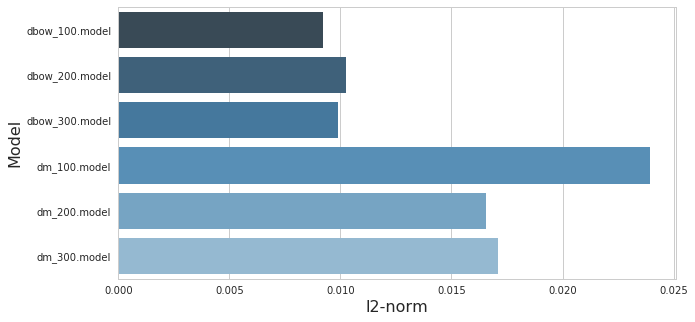

In [195]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
sns.barplot(doc_norm, models, palette="Blues_d")
plt.xlabel("l2-norm", fontsize=16)
plt.ylabel("Model", fontsize=16)
plt.show()

Заметим, что норма среднего вектора зависит от архитектуры модели. Для модели "распределенный мешок слов" норма среднего вектора значительно меньше, чем для среднего вектора аналогичной модели "распределенная память". 

#### l2-норма вектора документа

In [206]:
docs_id = list(model.docvecs.doctags.keys())
doc_mtx = model.docvecs.doctag_syn0
docs_norm = [np.linalg.norm(vec) for vec in doc_mtx]
docs_len = [model.docvecs.doctags[_id].word_count for _id in docs_id]
df_docs = pd.DataFrame({'id': docs_id, 'word_len': docs_len, 'l2-norm': docs_norm})
df_docs.head()

,id,l2-norm,word_len
0,0704.0069v1,14.203918,6187
1,0704.0129v1,7.005510,2375
2,0704.0390v3,6.325243,1949
3,0704.0698v1,16.106455,11482
4,0704.1006v1,6.167994,2647


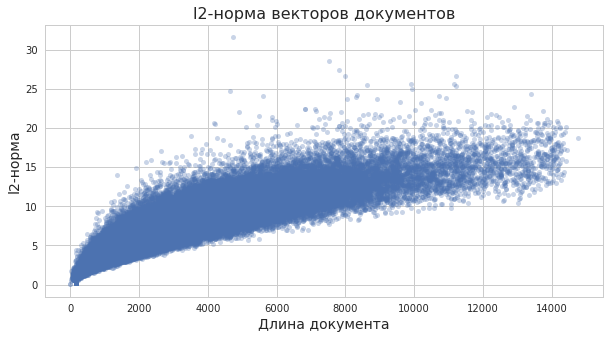

In [317]:
plt.figure(figsize=(10,5))
data = df_docs.sort_values(by='l2-norm', ascending=False)
plt.plot(data['word_len'], data['l2-norm'], 'o', alpha=0.3, ms=5.)
plt.title("l2-норма векторов документов", size=16)
plt.xlabel("Длина документа", size=14)
plt.ylabel("l2-норма", size=14)
plt.show()

In [321]:
print("Коэффицент корреляции Спирмена: %.3f" % spearmanr(data['word_len'], data['l2-norm']).correlation)

Коэффицент корреляции Спирмена: 0.923


Отметим **наличие зависимости** нормы вектора документа от кол-ва слов, которое содержит данный документ.

### Сингулярное разложение матрицы документов

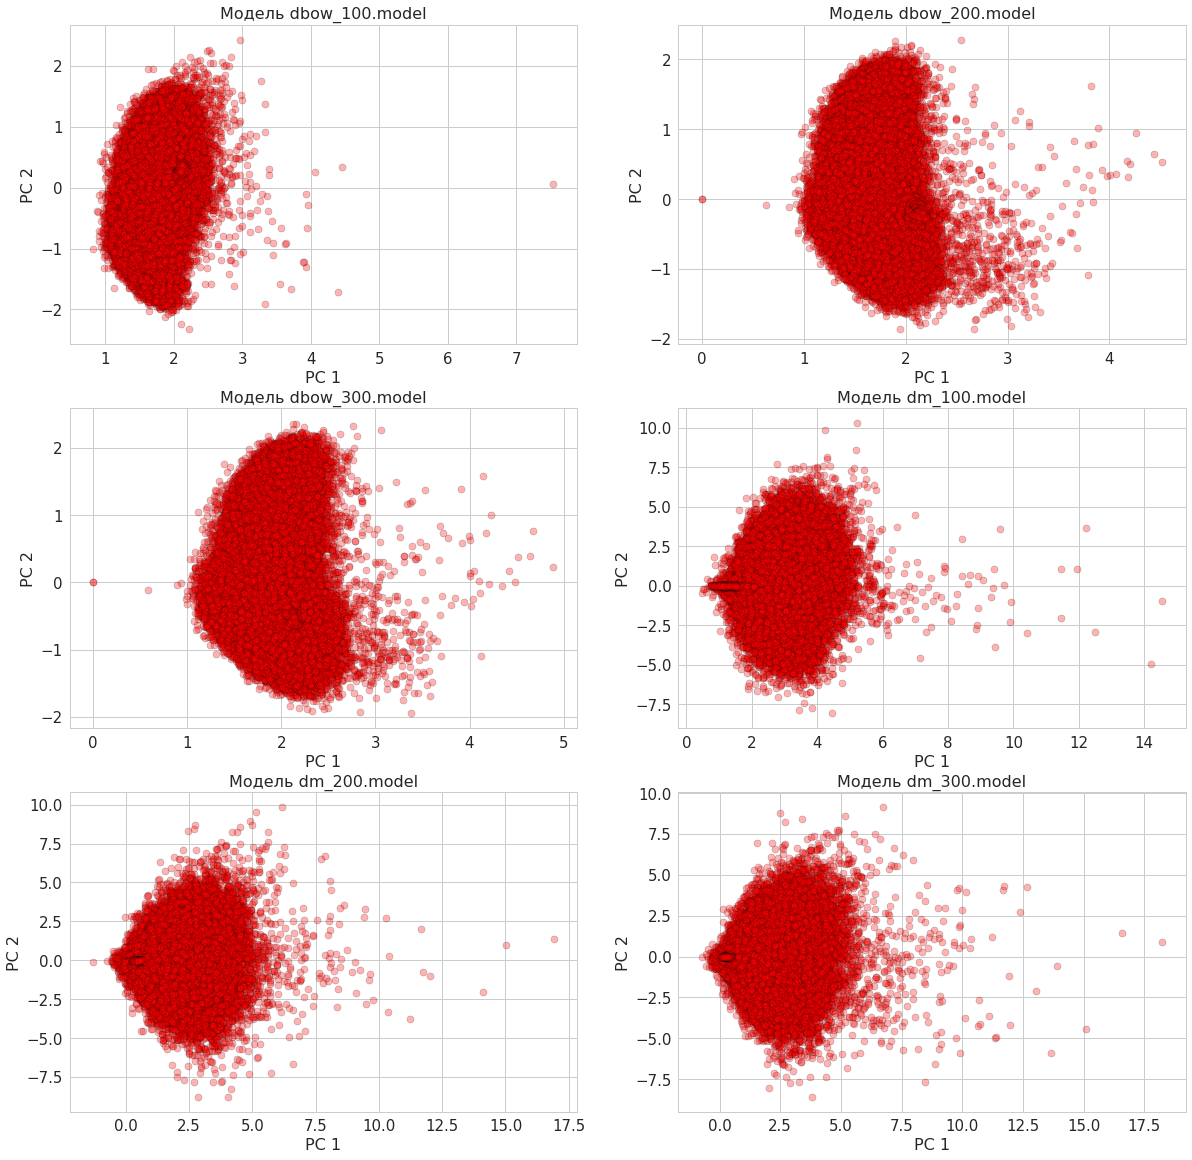

In [482]:
fig = plt.figure(figsize=(20,20))

for i, name in enumerate(models):
    model = Doc2Vec.load(path_to_model + name)
    doc_mtx = model.docvecs.doctag_syn0
    svd = TruncatedSVD(n_components=2, n_iter=20, random_state=0)
    proj = svd.fit_transform(doc_mtx)

    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(proj[:,0], proj[:,1], alpha=0.3, color='r', lw=0.5, s=50, edgecolor="black")
    plt.title('Модель ' + name, fontsize=16)
    plt.xlabel("PC 1", size=16)
    plt.ylabel("PC 2", size=16)
    
plt.show()

Посмотрим насколько разделимы 2D-проекции двух произвольных категорий, например, *'math.NT'* (теория чисел) и *'math.DG'* (дифференциальная геометрия).

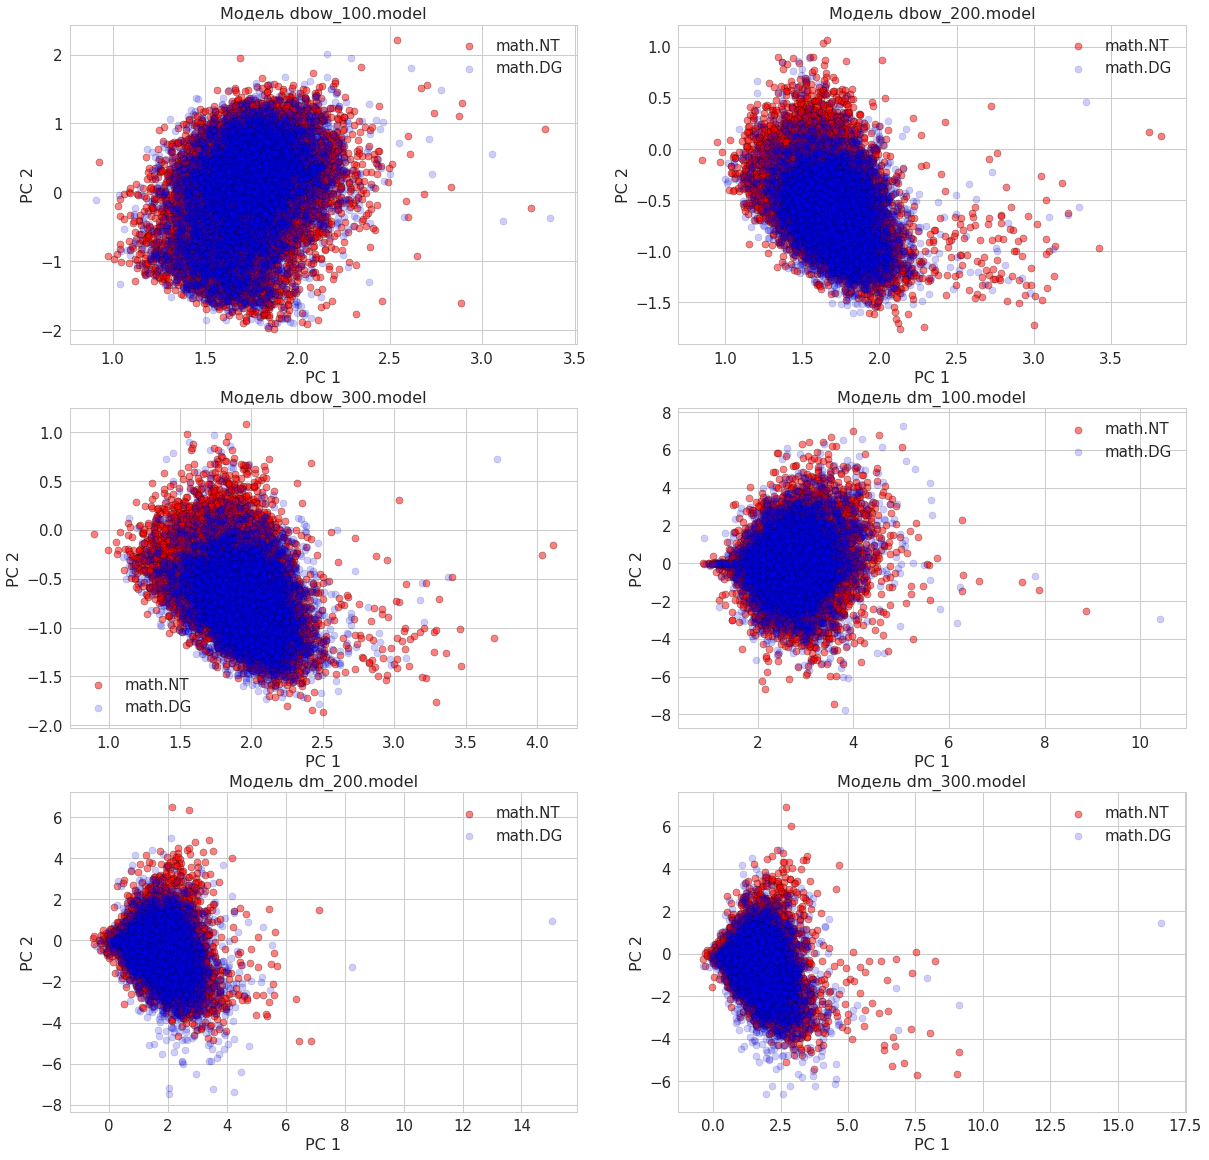

In [483]:
fig = plt.figure(figsize=(20,20))

for i, name in enumerate(models):
    model = Doc2Vec.load(path_to_model + name)
    y = corpus_info.loc[list(model.docvecs.doctags.keys())]['primary_category'].fillna('math.PR')
    y.reset_index(drop=True, inplace=True)
    math_ds = y[y == 'math.NT'].index
    quant_ph = y[y == 'math.DG'].index
    doc_mtx = model.docvecs.doctag_syn0

    svd = TruncatedSVD(n_components=2, n_iter=20, random_state=0)
    proj = svd.fit_transform(doc_mtx)

    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(proj[math_ds][:,0], proj[math_ds][:,1], alpha=0.5, color='r', label='math.NT', lw=0.5, s=50, edgecolor="black")
    ax.scatter(proj[quant_ph][:,0], proj[quant_ph][:,1], alpha=0.2, color='b', label='math.DG', lw=0.5, s=50, edgecolor="black")
    plt.title('Модель ' + name, fontsize=16)
    plt.xlabel("PC 1", size=16)
    plt.ylabel("PC 2", size=16)
    plt.legend()
plt.show()

### t-SNE
[Описание]  

*t-SNE* [10] -- алгоритм визулизации данных высокой размерности. Он позволяет нелинейно отобразить вектора документов на двумерную плоскость, при этом сохраняя локальную структуру пространства (пространства документов).

In [324]:
path_to_tsne = '/home/kulesh271828/arxiv/models/tsne/' 

In [468]:
name = 'dbow_300.model'
model = Doc2Vec.load(path_to_model + name)
X = model.docvecs.doctag_syn0.astype(np.float64)
y = corpus_info.loc[list(model.docvecs.doctags.keys())]['primary_category'].fillna('math.PR')
y.reset_index(drop=True, inplace=True)

**Обучение модели**

In [373]:
%%time 

print('SVD soft decomposition...')
svd = TruncatedSVD(n_components=50, n_iter=20, random_state=0)
proj = svd.fit_transform(X)

print('Transforming...')
tsne = TSNE(n_jobs=8, random_state=0, verbose=2, perplexity=50)
Y = tsne.fit_transform(proj)

SVD soft decomposition...
Transforming...
CPU times: user 2h 13min 35s, sys: 28min 28s, total: 2h 42min 4s
Wall time: 33min


**Категории**

In [376]:
y.unique()

array(['math.DS', 'math.PR', 'math.FA', 'math.RT', 'math.CA', 'astro-ph',
       'math.GR', 'cs.CV', 'math.DG', 'math.QA', 'cs.NI', 'cs.CL', 'cs.CC',
       'cs.SI', 'math.NA', 'math.OC', 'math-ph', 'math.NT', 'hep-th',
       'quant-ph', 'cs.AI', 'cs.IT', 'math.AG', 'math.OA', 'math.RA',
       'math.ST'], dtype=object)

In [470]:
sns.set()

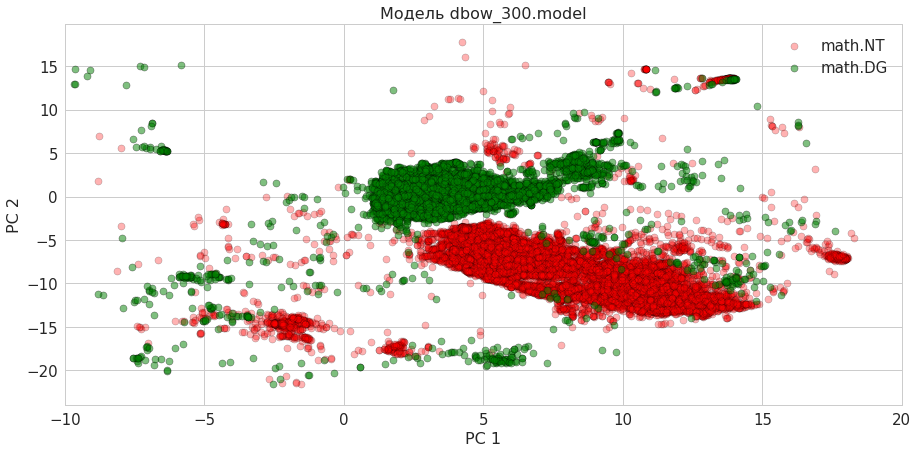

In [481]:
mask_1 = y[y == 'math.NT'].index
mask_2 = y[y == 'math.DG'].index

plt.figure(figsize=(15,7))
plt.scatter(Y[mask_1][:,0], Y[mask_1][:,1], alpha=0.3, c='r', lw=0.5, s=50, label='math.NT', edgecolor="black")
plt.scatter(Y[mask_2][:,0], Y[mask_2][:,1], alpha=0.5, c='g', lw=0.5, s=50, label='math.DG', edgecolor="black")
plt.title('Модель ' + name, fontsize=16)
plt.xlabel("PC 1", size=16)
plt.ylabel("PC 2", size=16)
plt.legend()
plt.xlim(-10,20)
plt.show()

С помощью алгоритма t-SNE можем наблюдать, что пространство документов имеет кластерную структуру: статьи одной категории оъединены в группы. Пока это предположение справедливо только для двух категорий. Теперь отобразим все категории.

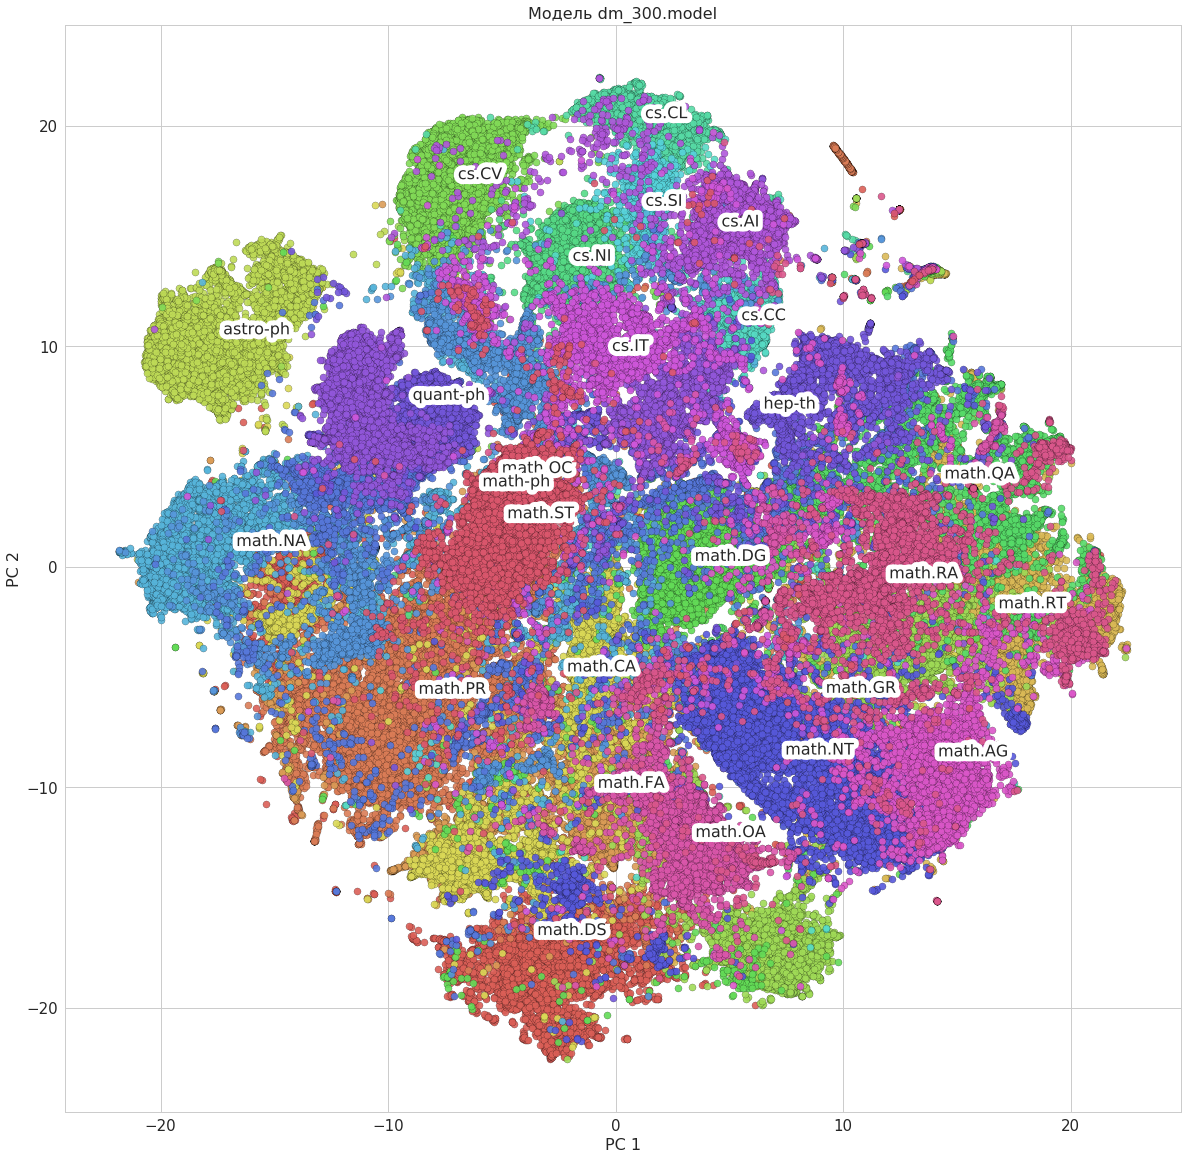

In [488]:
plt.figure(figsize=(20,20))
txts = []
palette = np.array(sns.color_palette("hls", 26))

for category, c in zip(y.unique(), palette):
    mask = y[y == category].index
    plt.scatter(Y[mask][:,0], Y[mask][:,1], alpha=0.9, color=c, label=category, lw=0.2, s=50, edgecolor="black")
    plt.title('Модель ' + name, fontsize=16)
    plt.xlabel("PC 1", size=16)
    plt.ylabel("PC 2", size=16)
    xtext, ytext = np.median(Y[mask], axis=0)
    txt = plt.text(xtext, ytext, category, fontsize=16)
    txt.set_path_effects([
            PathEffects.Stroke(linewidth=10, foreground="w"),
            PathEffects.Normal()])
    txts.append(txt)
    
plt.show()

Видим, что гипотеза о кластерной структуре пространства документов подтвердилась. Но некоторые категории представлены несколькими кластерами. Возможно, это объясняется тем, что в 300-мерном пространстве данные разных категорий имеют разную дисперсию, поэтому полученное отображение имеет метрические искажение. Этот момент будет исследован, но уже в другой тетрадке.

#### Вектор целевой переменной

In [464]:
y = corpus_info.loc[list(model.docvecs.doctags.keys())]['primary_category'].fillna('math.PR')
y.to_csv('target_d2v.csv', index=False, header=True)

In [465]:
pd.read_csv('target_d2v.csv').head()

,primary_category
0,math.DS
1,math.DS
2,math.DS
3,math.DS
4,math.DS


# Классификация

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, make_scorer

In [10]:
path_to_model = '/home/kulesh271828/arxiv/models/doc2vec/'

In [ ]:
model = Doc2Vec.load(path_to_model + name)

In [ ]:
def modeling(clf, parameters, X, y, name, postprocessing=True, k=5, n_jobs=8, verbose=2):
    '''
    Desciption
    '''
    if normalizing:
        X = normalize(X, norm='l2', axis=1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_test, test_size=0.3)
    print("Train size: %d" % X_train.shape[0])
    print("Test size: %d" % X_test.shape[0])
    
    skf = StratifiedKFold(n_splits=k, random_state=seed_valid)
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    gs = GridSearchCV(clf, parameters, cv=skf, verbose=verbose, n_jobs=n_jobs, scoring=f1_scorer)
    print("Searching best parameters...")
    gs.fit(X_train, y_train)
    pickling_data(name, gs)
    print("Best parameters: %s" % gs.best_params_)
    
    ind = gs.best_index_
    mean_train = gs.cv_results_['mean_train_score'][ind]
    std_train = gs.cv_results_['std_train_score'][ind]
    mean_valid = gs.cv_results_['mean_test_score'][ind]
    std_valid = gs.cv_results_['std_test_score'][ind]
    
    print("Training best model on full train data...")
    clf = gs.best_estimator_
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_test = f1_score(y_pred, y_test, average='weighted')
    
    print("Train score: %.3f +/- %.3f" % (mean_train, std_train))
    print("CV score: %.3f +/- %.3f" % (mean_valid, std_valid))
    print("Test score: %.3f\n" % score_test)

## Источники
1. [models.doc2vec](http://radimrehurek.com/gensim/models/doc2vec.html) – Deep learning with paragraph2vec  
- Doc2vec in gensim [tutorial lee](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb
) | [tutorial imdb](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb) | [tutorial wiki](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-wikipedia.ipynb)
- Andrew M. Dai, Christopher Olah, Quoc V. Le. [Document Embedding with Paragraph Vectors](https://arxiv.org/abs/1507.07998)  
- Quoc Le and Tomas Mikolov. [Distributed Representations of Sentences and Documents](http://www-cs-faculty.stanford.edu/~quocle/paragraph_vector.pdf)  
- Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf). In Proceedings of Workshop at ICLR, 2013.  
- Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-com.pdf). In Proceedings of NIPS, 2013.  
- [An Empirical Evaluation of doc2vec with Practical Insights into Document Embedding Generation](https://arxiv.org/pdf/1607.05368.pdf)  
- Dimensionality reduction using truncated SVD [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)  
- Коэффициент корреляции Спирмена [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html)  
- Laurens van der Maaten, Geoffrey Hinton. [Visualizing High-Dimensional Data Using t-SNE](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)